 Ankith Jain: EM23MTECH14004





# **TRUST RANK ASSIGNMENT**

**IMPORTS**

In [ ]:
# Importing necessary libraries/modules
from numpy import mat, eye, zeros, ones, linalg  # NumPy for numerical operations
import random  # For generating random numbers
import pandas as pd  # Pandas for data manipulation and analysis
import numpy as np  # NumPy for numerical operations (again)
from collections import defaultdict, OrderedDict  # Collections for specialized container datatypes
import collections  # Collections module for general container datatypes
import threading  # Threading for multi-threading support
import time  # Time for time-related functions
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# The code above imports various libraries/modules for numerical operations,
# data manipulation, threading, and time-related functionalities.


**DESCRIPTION OF THE DATASET**


The dataset "Payments.csv" represents a directed graph, where nodes signify senders and receivers of transactions, and the transaction amount denotes the value exchanged between them. Each transaction is associated with a significance value, reflecting the importance of the transaction between the parties involved.

Furthermore, the "bad_sender.csv" file contains a curated list of 20 nodes identified as bad senders, serving as a seed set for the analysis. These nodes are suspected to engage in malicious or fraudulent activities within the network.

In contrast, there are a total of 779 nodes categorized as good nodes, representing entities that are not associated with fraudulent behavior.

This dataset and seed set are utilized in the study to develop and evaluate a TrustRank-based algorithm aimed at identifying suspicious nodes within the network effectively.


In [ ]:
pd.read_csv('/content/Payments.csv')

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396
...,...,...,...
130530,1344,1390,21739
130531,1914,1390,3374
130532,1914,1390,5186
130533,1914,1390,1559


In [ ]:
pd.read_csv('/content/bad_sender.csv')

,Bad Sender
0,1303
1,1259
2,1562
3,1147
4,1393
5,1031
6,1210
7,1042
8,1048
9,1256


**PREGEL FRAMEWORK**

In [ ]:
class Vertex():
    def __init__(self, id, value, out_vertices):
        # Initialize the vertex with its ID, value, outgoing vertices,
        # incoming and outgoing message lists, superstep number,
        # and active status.
        self.id = id
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0

class Pregel():
    def __init__(self, vertices, num_workers):
        # Initialize Pregel instance with vertices and number of workers.
        self.vertices = vertices
        self.num_workers = num_workers

    def run(self):
        """Runs the Pregel instance."""
        # Partition vertices among workers and execute supersteps until all vertices are inactive.
        self.partition = self.partition_vertices()
        while self.check_active():
            self.superstep()
            self.redistribute_messages()

    def partition_vertices(self):
        """
        Partition vertices equally among workers.
        Returns a dictionary with keys 0 to num_workers-1
        representing worker threads and values as lists of vertices assigned to each worker.
        """
        partition = collections.defaultdict(list)
        each = len(self.vertices) // self.num_workers

        for i in range(self.num_workers):
            partition[i] = self.vertices[i * each: (i + 1) * each]

            if i == self.num_workers - 1:
                partition[i] = self.vertices[i * each:]

        return partition

    def superstep(self):
        """Completes a single superstep by creating worker threads."""
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            worker.start()
        for worker in workers:
            worker.join()

    def redistribute_messages(self):
        """Updates the message lists for all vertices."""
        # Increment superstep for all vertices and clear incoming messages.
        for vertex in self.vertices:
            vertex.superstep += 1
            vertex.incoming_messages = []
        # Redistribute outgoing messages to corresponding receiving vertices.
        for vertex in self.vertices:
            for (receiving_vertex, message) in vertex.outgoing_messages:
                receiving_vertex.incoming_messages.append((vertex, message))

    def check_active(self):
        """Returns True if there are any active vertices, and False otherwise."""
        # Check if any vertex is active.
        return any([vertex.active for vertex in self.vertices])

class Worker(threading.Thread):
    def __init__(self, vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        # Execute superstep for the vertices assigned to this worker.
        self.superstep()

    def superstep(self):
        """Completes a single superstep for all vertices assigned to the worker."""
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()  # Main computation for TrustRank is done here.


**Functions**

In [ ]:
def intialTrustRank(nodes, bad_nodes):
    """
    Initiallizes the initial ranking based on the bad nodes.
    """
    score = np.zeros(len(nodes))  # Initialize an array for scores with zeros.
    for i in bad_nodes:
        score[i] = 1 / len(bad_nodes)  # Assign equal score to each bad node.
    return list(score)

def get_connections(edge_file, nodes_dict, nodes, bad_nodes):
    """
    get edges - if there are no outgoing link, point it to all the bad nodes with equal weightage - handles leakage
    """
    edges_mapped = defaultdict(list)
    edges = defaultdict(list)
    values = {}  # Initialize dictionaries to store edge mappings and values.
    for i in range(len(edge_file)):
        from_, to_, value = int(edge_file.iloc[i][0]), int(edge_file.iloc[i][1]), int(edge_file.iloc[i][2])  # Extract edge information.
        if to_ not in edges[from_]:
            edges[from_].append(to_)  # Store edges in a dictionary.
            edges_mapped[nodes_dict.get(from_)].append(nodes_dict.get(to_))

        if len(values.get(nodes_dict.get(from_), [])) == 0:
            values[nodes_dict.get(from_)] = {}
            values[nodes_dict.get(from_)][nodes_dict.get(to_)] = 0  # Initialize edge values.

        values[nodes_dict.get(from_)][nodes_dict.get(to_)] = values[nodes_dict.get(from_)].get(nodes_dict.get(to_), 0) + value  # Sum edge values.

    # Handling leakage by connecting nodes back to the bad nodes with equal weightage.
    empty = list(set(nodes).difference(set(edges_mapped.keys())))
    for i in empty:
        edges_mapped[i] = edges_mapped.get(i, []) + bad_nodes  # Add bad nodes to nodes without outgoing links.
        values[i] = {}
        for j in bad_nodes:
            values[i][j] = 1  # Assign equal weightage to links from nodes without outgoing links to bad nodes.

    return edges, edges_mapped, values, nodes

def PregelTrustRank(vertices):
    """
    Compute Pagerank using pregel by assigning a set of vertices to thread.

    [x] there is a bug in the provided pregel code where all the vertices are run using a single worker
    irrespective of the number of workers. This is because of the way the workers are assigned.
    """

    p = Pregel(vertices, num_workers=4)  # Initialize Pregel instance with vertices and number of workers.
    p.run()  # Execute Pregel algorithm.
    return mat([vertex.value for vertex in p.vertices]).transpose(), p  # Return the final values of vertices and Pregel instance.

class TrustRankVertex(Vertex):
    """
    Vertex class for TrustRank algorithm.
    """
    def __init__(self,id,value,out_vertices, weightage_values, dampingFactor=0.85,iterations=50):
        Vertex.__init__(self,id,value,out_vertices)  # Initialize vertex with ID, value, outgoing vertices, etc.
        self.dampingFactor = dampingFactor  # Set damping factor.
        self.num_supersteps = iterations  # Set number of iterations.
        self.weightage_values = weightage_values  # Set weightage values for outgoing links.
        self.values_iterations = []  # Initialize list to store values of iterations.
        self.d = value  # Set value of d for TrustRank equation.

    def update(self):
        """
        CHANGES MADE:
        [x] Leakage is handled by connecting nodes with no outlinks back to bad nodes with equal weights
        [x] Outgoing messages earlier were divided equally by all outgoing links. Now they are
        instead multiplied by the weightage of each link which is based on normalized values of outgoing links.
        """
        if self.superstep < self.num_supersteps:
            messages_sum = 0
            for (vertex,message) in self.incoming_messages:
                messages_sum = messages_sum+message  # Sum incoming messages.
            self.value = self.dampingFactor * messages_sum + (1 - self.dampingFactor) * self.d  # Calculate new value based on TrustRank equation.
            outgoing_message_all = [self.value * weight for weight in self.weightage_values]  # Multiply by weightage of each link.
            self.outgoing_messages = [(vertex, outgoing_message) for vertex, outgoing_message in zip(self.out_vertices, outgoing_message_all)]  # Store outgoing messages.
            self.values_iterations.append(self.value)  # Append value to list of iterations.
        else:
            self.active = False  # Deactivate vertex if maximum number of iterations is reached.


**Main Code**

Load the dataset

In [ ]:
df = pd.read_csv('/content/bad_sender.csv')
data = pd.read_csv('/content/Payments.csv')
# load nodes
_bad_nodes = list(set(pd.read_csv('/content/bad_sender.csv')["Bad Sender"]))
_nodes  = list(set(list(set(data["Sender"])) + list(set(data["Receiver"])) ))

In [ ]:
nodes_dict = dict(zip( _nodes, np.arange(len(_nodes))))

# mapping nodes
nodes = [nodes_dict.get(i) for i in _nodes]
bad_nodes = [nodes_dict.get(i) for i in _bad_nodes]

Get the edges

In [ ]:
# if there are no outgoing link, create synthetic link to the bad nodes with equal weightage to prevent leakage
edges, edges_mapped, values, nodes = get_connections(data, nodes_dict, nodes, bad_nodes)

Initialize rank to nodes

In [ ]:
nodes_intial_ranks = intialTrustRank(nodes, bad_nodes)

Create the graph among the node

In [ ]:

# intialize the vertices with modified Vertex class
num_vertices = len(nodes)
vertices = []
for i in range(len(nodes)):
    vertices.append(TrustRankVertex(nodes[i],nodes_intial_ranks[i],[],[], 0.85, 100))

# assign out vertex with weightage for each node based on the values
for i in edges_mapped.keys():
    weightage = [j / sum(list(values[i].values())) for j in list(values[i].values())]
    for j, k in zip(edges_mapped[i], weightage):
        vertices[i].out_vertices.append(vertices[j])
        vertices[i].weightage_values.append(k)

Compute the Pagerank

In [ ]:
node_ranks, p = PregelTrustRank(vertices)

print(f"Pregel TrustRank result : \n {dict(zip(nodes, node_ranks.A1))}")

Pregel TrustRank result : 
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.002092545823346117, 59: 0.00016550381939594766, 60: 0.000366090651100435, 61: 0.0038996369281061043, 62: 0.009097330806715667, 63: 0.0008871402878598143, 64: 0.039912113200067253, 65: 0.002181431479652059, 66: 0.0, 67: 0.0004671464752279273, 68: 0.012446924003297659, 69: 0.0, 70: 0.011983031675886026, 71: 0.0031039284044368956, 72: 0.0, 73: 0.007579215786432508, 74: 0.0, 75: 0.0, 76: 3.85888687256371e-05, 77: 0.0014518003772599384, 78: 0.00722262020

**Results**



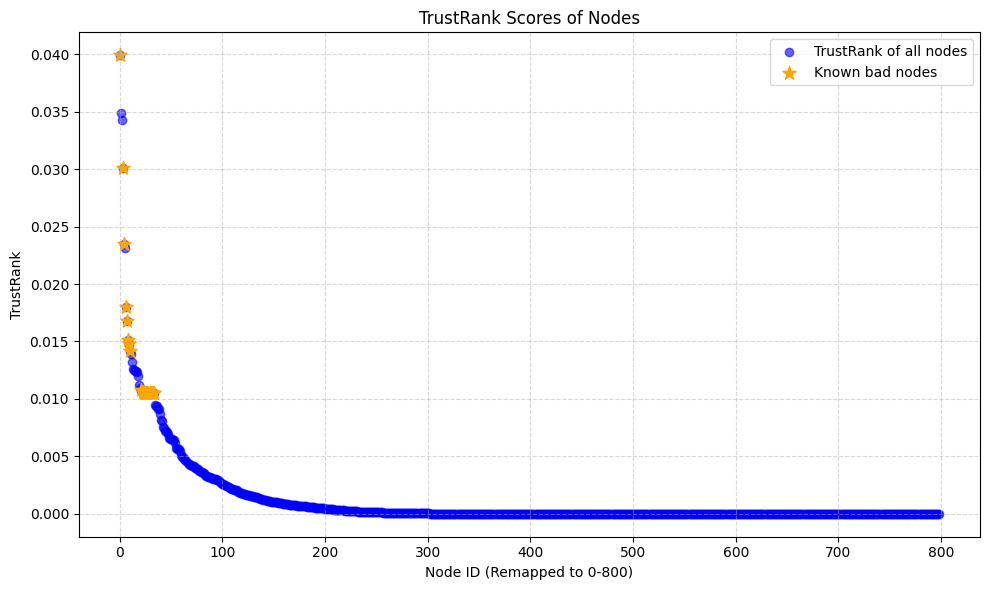

Number of bad nodes: 20
Number of good nodes: 779


In [ ]:
# Create an ordered dictionary mapping node names to TrustRank scores
d = OrderedDict(zip(nodes, node_ranks.A1))

# Sort the dictionary based on TrustRank scores and extract the sorted node names
res = list(OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True)))

# Find the maximum TrustRank score
ub = max(node_ranks.A1)

# Create a mapping dictionary to map node names to their sorted positions
mapping = dict(zip(res, np.arange(len(res))))

# Sort TrustRank scores in descending order
mapping2 = sorted(node_ranks.A1, reverse=True)

# Map positions of bad nodes to their indices in the sorted list of TrustRank scores
mapping3 = [mapping[i] for i in bad_nodes]

# Plot TrustRank scores with custom appearance
plt.figure(figsize=(10, 6))

# Plot TrustRank scores of all nodes
plt.scatter(np.arange(len(res)), sorted(node_ranks.A1, reverse=True), label="TrustRank of all nodes", color="blue", alpha=0.6)

# Highlight known bad nodes with asterisks
plt.scatter([mapping[i] for i in bad_nodes], [mapping2[i] for i in mapping3], marker="*", color="orange", label="Known bad nodes", s=100)

# Set labels and title for the plot
plt.xlabel("Node ID (Remapped to 0-800)")
plt.ylabel("TrustRank")
plt.title("TrustRank Scores of Nodes")
plt.legend()  # Add legend to the plot
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines with dashed style
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Display the plot

# Print the number of bad nodes and good nodes
num_bad_nodes = len(bad_nodes)
num_good_nodes = len(res) - num_bad_nodes
print("Number of bad nodes:", num_bad_nodes)
print("Number of good nodes:", num_good_nodes)


From the plot above we can see that the majority of the ground-truth bad nodes have a higher scores. This shows that the algorithm has worked as intended.

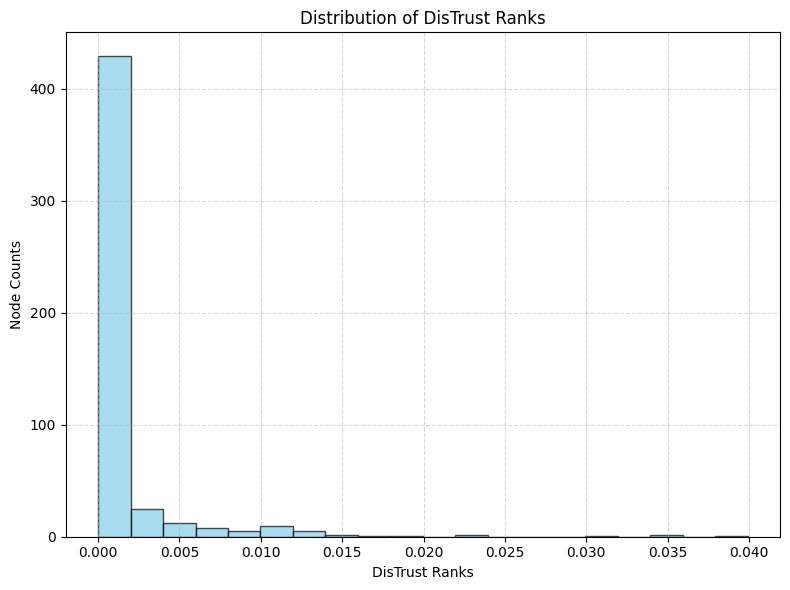

In [ ]:
# Plot histogram with custom appearance
plt.figure(figsize=(8, 6))  # Create a new figure with a specified size (8 inches wide, 6 inches high)

# Create a histogram of TrustRank scores with 20 bins, normalized to form a probability density, colored sky blue,
# with a transparency of 0.7, and black edges for each bin
plt.hist(node_ranks.A1, bins=20, density=1, color='skyblue', alpha=0.7, edgecolor='black')

# Set the label for the x-axis as "DisTrust Ranks"
plt.xlabel("DisTrust Ranks")

# Set the label for the y-axis as "Node Counts"
plt.ylabel("Node Counts")

# Set the title of the plot as "Distribution of DisTrust Ranks"
plt.title("Distribution of DisTrust Ranks")

# Add grid lines with dashed style and transparency of 0.5
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()


The above plot shows that most of the nodes have ranks between 0.00 and 0.01 while a few nodes have higher ranks indicating that the majority of the nodes are good nodes excluding a specific few.

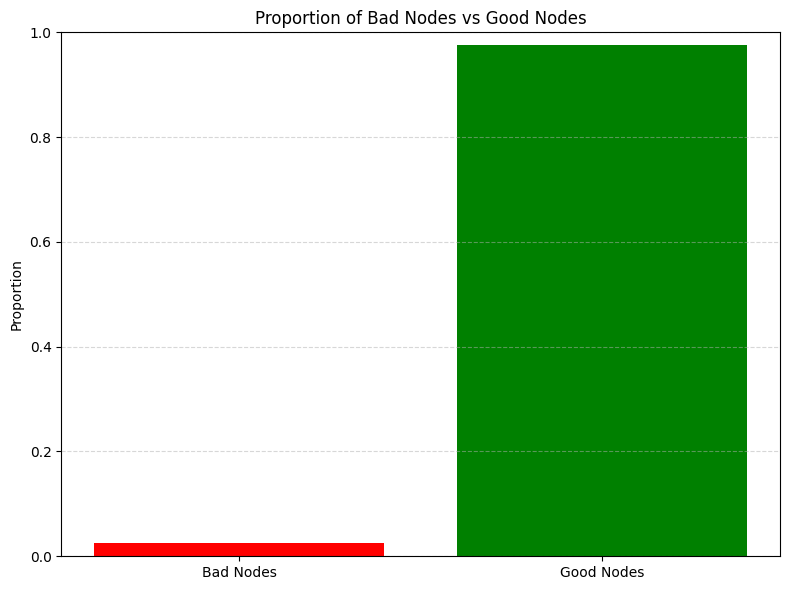

In [ ]:
# Calculate the proportion of bad nodes and good nodes
total_nodes = len(res)  # Total number of nodes
proportion_bad_nodes = len(bad_nodes) / total_nodes  # Proportion of bad nodes
proportion_good_nodes = 1 - proportion_bad_nodes  # Proportion of good nodes (complement of bad nodes)

# Create a bar plot to compare the proportions
plt.figure(figsize=(8, 6))  # Create a new figure with a specified size (8 inches wide, 6 inches high)

# Create a bar plot with two bars representing bad nodes and good nodes respectively,
# using their calculated proportions, colored red for bad nodes and green for good nodes
plt.bar(["Bad Nodes", "Good Nodes"], [proportion_bad_nodes, proportion_good_nodes], color=["red", "green"])

# Set the title of the plot as "Proportion of Bad Nodes vs Good Nodes"
plt.title("Proportion of Bad Nodes vs Good Nodes")

# Set the label for the y-axis as "Proportion"
plt.ylabel("Proportion")

# Set the y-axis limit to ensure proportions are displayed correctly (ranging from 0 to 1)
plt.ylim(0, 1)

# Add grid lines along the y-axis with dashed style and transparency of 0.5
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()
